**Spam Email Text Classification**

**Import Libraries**

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from matplotlib import pyplot as plt
import seaborn as sn

In [8]:
df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Quick Analysis**

In [9]:
df.groupby('Category').describe()

Message                                                             
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later  \
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

Imbalanced Dataset, we need to even it out.

We will use a technique called downsampling

In [12]:
#Create new datafrane
df_spam = df[df['Category'] == 'spam']
print('Shape Spam')
print(df_spam.shape)

#Create new datafrane
df_ham = df[df['Category'] == 'ham']
print('\nShape non-Spam')
print(df_ham.shape)

#sample a random 747 from the ham dataframe to have an even amount of training data
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
print('\nShape non-Spam Downsized')
print(df_ham_downsampled.shape)

#Concantenate
df_balanced = pd.concat([df_spam, df_ham_downsampled])
print('\nConcatenated Data; Spam + non-Spam Downsized')
print(df_balanced.shape)

Shape Spam
(747, 2)

Shape non-Spam
(4825, 2)

Shape non-Spam Downsized
(747, 2)

Concatenated Data; Spam + non-Spam Downsized
(1494, 2)


In [13]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [14]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2207,spam,"URGENT! Your mobile No 07xxxxxxxxx won a £2,00...",1
962,spam,URGENT! We are trying to contact U. Todays dra...,1
5570,ham,The guy did some bitching but I acted like i'd...,0
1118,spam,"449050000301 You have won a £2,000 price! To c...",1
1189,ham,All will come alive.better correct any good lo...,0


**Split the data for training and testing**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify = df_balanced['spam'])

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")

def sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [17]:
#test function

sentence_embedding([
    "500$ discount, hurry up",
    "Lets Golf"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7734201 , -0.5013771 , -0.80737454, ..., -0.60576564,
        -0.74096286,  0.8849831 ],
       [-0.86887604, -0.3361706 ,  0.38210472, ...,  0.39323705,
        -0.70544434,  0.9013512 ]], dtype=float32)>

**MODEL**

In [18]:
#Bert Layers
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = "text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural Network Layers
Layer_1 = tf.keras.layers.Dropout(0.1, name = 'dropout')(outputs['pooled_output'])
Layer_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(Layer_1)

#Final Model
my_model = tf.keras.Model(inputs = [text_input], outputs = [Layer_2])

In [19]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [50]:
my_model_metrics = [
    tf.keras.metrics.BinaryAccuracy(name = 'Binary Accuracy'),
    tf.keras.metrics.Precision(name = 'Precision'),
    tf.keras.metrics.Recall(name = 'Recall')
]

my_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = my_model_metrics
)

In [51]:
my_model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 113s 3s/step - loss: 0.6079 - Binary Accuracy: 0.6732 - Precision: 0.6720 - Recall: 0.6768
Epoch 2/10
35/35 [==============================] - 107s 3s/step - loss: 0.4949 - Binary Accuracy: 0.8018 - Precision: 0.7683 - Recall: 0.8643
Epoch 3/10
35/35 [==============================] - 107s 3s/step - loss: 0.4248 - Binary Accuracy: 0.8545 - Precision: 0.8428 - Recall: 0.8714
Epoch 4/10
35/35 [==============================] - 107s 3s/step - loss: 0.3813 - Binary Accuracy: 0.8786 - Precision: 0.8643 - Recall: 0.8982
Epoch 5/10
35/35 [==============================] - 107s 3s/step - loss: 0.3504 - Binary Accuracy: 0.8804 - Precision: 0.8660 - Recall: 0.9000
Epoch 6/10
35/35 [==============================] - 107s 3s/step - loss: 0.3299 - Binary Accuracy: 0.8991 - Precision: 0.8901 - Recall: 0.9107
Epoch 7/10
35/35 [==============================] - 107s 3s/step - loss: 0.3096 - Binary Accuracy: 0.9080 - Precision: 0.8946 - Recall: 0.9250

In [52]:
my_model.evaluate(X_test, y_test)

12/12 [==============================] - 37s 3s/step - loss: 0.2836 - Binary Accuracy: 0.9037 - Precision: 0.8756 - Recall: 0.9412


[0.28355422616004944,
 0.903743326663971,
 0.8756219148635864,
 0.9411764740943909]

**Model Analysis**

In [54]:
y_predicted = my_model.predict(X_test)
y_predicted = y_predicted.flatten()

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

12/12 [==============================] - 37s 3s/step


array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,

In [60]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[162,  25],
       [ 11, 176]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

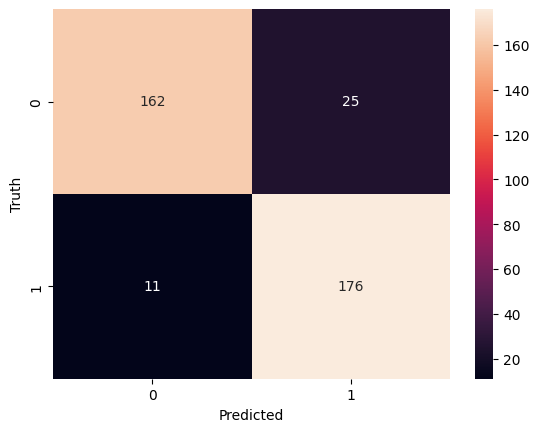

In [61]:
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       187
           1       0.88      0.94      0.91       187

    accuracy                           0.90       374
   macro avg       0.91      0.90      0.90       374
weighted avg       0.91      0.90      0.90       374

